In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import cPickle as pickle

from time import time
current_time = int(time())
print current_time
# python packages
import sys
import os
import glob
from socket import gethostname

from collections import defaultdict

import numpy as np
import pandas as pd

# scipy-project imports
import scipy.interpolate
import scipy.optimize
import scipy.stats
from scipy.special import erf, erfinv, erfc

sys.path.append("/home/lschumacher/svn_repos/skylab/trunk/doc/analyses/lschumacher-UHECR/")

# Misc
import ic_utils as utils

# Plotting
import seaborn as sns
sns.set_context("talk")
sns.set_style("whitegrid")
from matplotlib.colors import LogNorm
mpl = sns.mpl
plt = mpl.pyplot
#plt = utils.plotting("pdf")

from scipy.interpolate import UnivariateSpline

from prior_generator import UhecrPriorGenerator



print ":)"

print "8===D"

print(gethostname())
savepath, crpath, figurepath = utils.get_paths(gethostname())
print savepath
print figurepath

#savepath = os.path.join(savepath, "merged")

1531404646
Could not import from icecube, coordinate operations will not be possible
:)
8===D
cobalt03.icecube.wisc.edu
/data/user/lschumacher/projects/stacking/hotspot_fitting/merged
/home/lschumacher/public_html/uhecr_stacking/hotspot_fit/merged


In [3]:
from scipy.stats import chi2

## Read UHECR data

In [4]:
n_cr = dict()
pg = UhecrPriorGenerator(6)
for e in np.arange(50, 160, 5):
    pg._get_UHECR_positions(e, crpath, files=['AugerUHECR2014.txt', 'TelArrayUHECR.txt'])
    n_cr[e] = pg.n_uhecr
    
print n_cr

{130: 3, 135: 2, 140: 2, 145: 1, 150: 1, 155: 1, 50: 315, 55: 241, 60: 175, 65: 122, 70: 87, 75: 52, 80: 40, 85: 27, 90: 20, 95: 16, 100: 15, 105: 12, 110: 9, 115: 8, 120: 5, 125: 4}


## Read Background trials

In [69]:
import ic_utils as utils

In [70]:
identifiers = ["ic-ant", "ic-ant-scan"]

In [71]:
res_keys = ['nsources', 'TS', 'ra', 'dec', 'gamma', "cr_e_inj"]
mdparams = [3, 6]
pop_it = ["fit", "grid"]
save_it = "grid"
ecut = 70 

#identifier = "svn"
# always low cut for background, can be adjusted later on
# .... if i actually saved the energy key -__-
# Maybe I can just reconstruct it with the energy list of pg
bg_TS = dict()
shifts = []
nfiles = dict()
folders = []
for md in mdparams:
    nfiles[md] = 0
    print md
    print " * "*20
    for identifier in identifiers:
        folders.extend(sorted(glob.glob(os.path.join(savepath, "bckg_15*_{}_*_mdparams-{}_ecut-{}*".format(identifier, md, ecut)))))
    print folders
    for f in folders:
        inputfiles = sorted(glob.glob(os.path.join(savepath, f, "job-*_hotspot-*.json")))
        nfiles[md] += len(inputfiles)

3
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
[]
6
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
['/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/bckg_1530299693_ic-ant_1_mdparams-6_ecut-70_mu-0_srcgamma-2.19_shift-0_nsamples-2', '/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/bckg_1530524614_ic-ant_1_mdparams-6_ecut-70_mu-0_srcgamma-2.19_shift-0_nsamples-2', '/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/bckg_1530912456_ic-ant-scan_7_mdparams-6_ecut-70_mu-0_srcgamma-2.19_shift-0_nsamples-2']


In [72]:
nfiles

{3: 0, 6: 2500}

In [73]:
for md in mdparams:
    if nfiles[md]==0: continue
    bg_TS[md] = np.zeros((nfiles[md], n_cr[ecut]), dtype=[(str(k), np.float )for k in res_keys])
    counter = 0
    print md
    print " * "*20
    for f in folders:
        inputfiles = sorted(glob.glob(os.path.join(savepath, f, "job-*_hotspot-*.json")))
        # loop over all files in particular folder
        # one file corresponds to one trial!
        for i,infile in enumerate(inputfiles):
            data = utils.load_json_data(infile)
            # make a temp variable to hold the keys used later for analysis
            temp = np.ones((len(data),), dtype=[(str(k), np.float )for k in res_keys])
            for j,(prior,val) in enumerate(data.iteritems()):
                try:
                    pri = int(prior.split("_")[-1])
                    temp[j]["cr_e_inj"] = val.pop("cr_e", cr_energies[pri])
                    for k in res_keys:
                        if "_inj" not in k:
                            if "best" in val:
                                temp[j][str(k)] = val["best"][k]
                            else:
                                temp[j][str(k)] = val["grid"][k]
                    """except KeyError:
                    pri = int(prior.split("_")[-1])
                    temp[j]["cr_e_inj"] = cr_energies[pri]
                    for k in res_keys:
                        if "_inj" not in k:
                            temp[j][str(k)] = val["grid"][k]"""
                except Exception as e:
                    print infile
                    print data
                    print val
                    print k, j
                    print pri, prior
                    raise(e)
                    
            #print temp
            bg_TS[md][counter] = temp
            counter += 1
            #break
        #break
    #break
print "done"

6
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
done


In [74]:
name = "{}_{}_bg_TS_dict.pickle".format(current_time, identifier)
print name
with open(os.path.join(savepath, name), "wb") as f:
    pickle.dump(bg_TS, f)


1531073912_ic-ant-scan_bg_TS_dict.pickle


In [154]:
name = sorted(glob.glob(os.path.join(savepath,"*_bg_TS_dict.pickle")))
print name

['/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1529668447_bg_TS_dict.pickle', '/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1529931230_bg_TS_dict.pickle', '/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1530523183_ic-ant_bg_TS_dict.pickle', '/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1530523183_svn_bg_TS_dict.pickle', '/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1530541233_ic-ant_bg_TS_dict.pickle', '/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1530882235_ic-ant_bg_TS_dict.pickle', '/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1531073912_ic-ant-scan_bg_TS_dict.pickle']


In [5]:
with open('/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1530523183_svn_bg_TS_dict.pickle', "rb") as f:
    bg_TS = pickle.load(f)

## Read Signal trials

In [23]:
identifier = "ic-ant-scan"

In [ ]:
mdparams-6_ecut-70_mu-2_srcgamma-2.19_shift-5_nsamples-2

In [33]:
print inputfiles[6][70][0].keys()
print inputfiles[6][70][5].keys()

[1.0, 2.0, 4.0]
[1.0, 2.0, 4.0]


In [46]:
np.array(inputfiles[6][70][5][1]).shape

(461,)

In [37]:
print [len(inputfiles[6][70][0][mu]) for mu in inputfiles[6][70][0]]
print [len(inputfiles[6][70][5][mu]) for mu in inputfiles[6][70][5]]


[300, 290, 300]
[461, 469, 473]


In [47]:
print mus
print mdparams
print ecuts
print shifts

[2.0, 4.0, 6.0, 2.0, 4.0, 6.0, 2.0, 4.0, 1.0, 2.0, 4.0, 3.0, 2.0, 4.0, 1.0, 2.0, 4.0, 3.0]
[6.0]
[85.0, 100.0, 70.0]
[0.0, 0.0, 0.0, 5.0, 5.0, 5.0]


In [48]:
res_keys = ['nsources', 'TS', 'ra', 'dec', 'gamma']
inj_keys = ['nsources', 'cr_e', 'dec', 'ra']
save_keys = ['nsources', 'TS', 'ra', 'dec', 'gamma', 'nsources_inj', 'cr_e_inj', 'dec_inj', 'ra_inj']

#print res_keys+inj_keys

#identifier = "ic-ant"
#identifier = "svn"
sig_TS = dict()
mdparams= []
ecuts = []
shifts = []
all_inputfiles = sorted(glob.glob(os.path.join(savepath, "signal_15*_{}_*/".format(identifier), "job-*_hotspot-*.json")))
folders = sorted(glob.glob(os.path.join(savepath, "signal_15*_{}_*/".format(identifier))))
snfiles = dict()
scounter = dict()
inputfiles = dict()

for f in folders:
    #print f
    parts = f.split("_")
    for p in parts:
        if "shift-" in p:
            s = float(p.split("-")[-1])
        if "mu-" in p:
            mu = float(p.split("-")[-1])
        if "mdparams-" in p:
            md = float(p.split("-")[-1])
        if "ecut-" in p:
            ecut = float(p.split("-")[-1])
    if md not in sig_TS: 
        sig_TS[md] = dict()
        snfiles[md] = dict()
        scounter[md] = dict()
        inputfiles[md] = dict()
        mdparams.append(md)
        #print "md=", md
    if ecut not in sig_TS[md]: 
        sig_TS[md][ecut] = dict()
        snfiles[md][ecut] = dict()
        scounter[md][ecut] = dict()
        inputfiles[md][ecut] = dict()
        ecuts.append(ecut)
        #print "ecut=", ecut
    if s not in sig_TS[md][ecut]: 
        sig_TS[md][ecut][s] = dict()
        snfiles[md][ecut][s] = dict()
        scounter[md][ecut][s] = dict()
        inputfiles[md][ecut][s] = dict()
        shifts.append(s)
        #print "shift=", s
    if mu not in sig_TS[md][ecut][s]:
        snfiles[md][ecut][s][mu] = 0
        scounter[md][ecut][s][mu] = 0
        sig_TS[md][ecut][s][mu] = dict()
        inputfiles[md][ecut][s][mu] = []
        #print "mu=", mu
        
    infiles = sorted(glob.glob(os.path.join(savepath, f, "job-*_hotspot-*.json")))
    inputfiles[md][ecut][s][mu].extend(infiles)
    snfiles[md][ecut][s][mu] += len(infiles)

print snfiles

for f in folders:
    print f
    parts = f.split("_")
    for p in parts:
        if "shift-" in p:
            s = float(p.split("-")[-1])
        if "mu-" in p:
            mu = float(p.split("-")[-1])
        if "mdparams-" in p:
            md = float(p.split("-")[-1])
        if "ecut-" in p:
            ecut = float(p.split("-")[-1])
    if "data" not in sig_TS[md][ecut][s][mu]:
        #sig_TS[md][ecut][s][mu]["data"] = np.ones((snfiles[md][ecut][s][mu], n_cr[ecut]), dtype=[(str(k), np.float )for k in save_keys])
        sig_TS[md][ecut][s][mu]["data"] = np.ones((len(inputfiles[md][ecut][s][mu]), n_cr[ecut]), 
                                                  dtype=[(str(k), np.float )for k in save_keys])
        sig_TS[md][ecut][s][mu]["phi0"] = 0.
    else:
        continue
        
    #inputfiles = sorted(glob.glob(os.path.join(savepath, f, "job-*_hotspot-*.json")))
    for i,infile in enumerate(inputfiles[md][ecut][s][mu]):
        data = utils.load_json_data(infile)
        temp = np.ones((len(data),), dtype=[(str(k), np.float )for k in save_keys])
        for j,(_,val) in enumerate(data.iteritems()):
            for k in res_keys:
                temp[j][str(k)] = val["best"][k]
            for k in inj_keys:
                temp[j][str(k)+"_inj"] = val["inj"][k]
        try:
            sig_TS[md][ecut][s][mu]["data"][scounter[md][ecut][s][mu]] = temp
            scounter[md][ecut][s][mu] += 1
        except Exception as e:
            print scounter[md][ecut][s][mu]
            print i
            print len(inputfiles[md][ecut][s][mu])
            print len(sig_TS[md][ecut][s][mu]["data"])
            err, info, tb = sys.exc_info()
            traceback.print_exc()
            #raise(e)
        #break
    trialfile = os.path.join(savepath, f, "trials_dict.json")
    sig_TS[md][ecut][s][mu]["phi0"] = utils.load_json_data(trialfile)["phi0"]
    #break
print "done"

name = "{}_{}_sig_TS_dict.pickle".format(current_time, identifier)
print name
with open(os.path.join(savepath, name), "wb") as f:
    pickle.dump(sig_TS, f)

{6.0: {100.0: {0.0: {2.0: 300, 4.0: 300, 6.0: 300}, 5.0: {2.0: 521, 3.0: 514, 4.0: 523}}, 85.0: {0.0: {2.0: 300, 4.0: 300, 6.0: 300}, 5.0: {2.0: 300, 3.0: 300, 4.0: 300}}, 70.0: {0.0: {1.0: 300, 2.0: 290, 4.0: 300}, 5.0: {1.0: 461, 2.0: 469, 4.0: 473}}}}
/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/signal_1530912456_ic-ant-scan_1_mdparams-6_ecut-85_mu-2_srcgamma-2.19_shift-0_nsamples-2/
/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/signal_1530912456_ic-ant-scan_2_mdparams-6_ecut-85_mu-4_srcgamma-2.19_shift-0_nsamples-2/
/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/signal_1530912456_ic-ant-scan_3_mdparams-6_ecut-85_mu-6_srcgamma-2.19_shift-0_nsamples-2/
/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/signal_1530912456_ic-ant-scan_4_mdparams-6_ecut-100_mu-2_srcgamma-2.19_shift-0_nsamples-2/
/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/signal_1530912456_ic-ant-scan_5_mdparams-6_ecut-100_mu-4_srcgamm

In [6]:
with open("/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1530523183_svn_sig_TS_dict.pickle", "rb") as f:
    sig_TS = pickle.load(f)

In [7]:
identifier = "svn"

## Background only

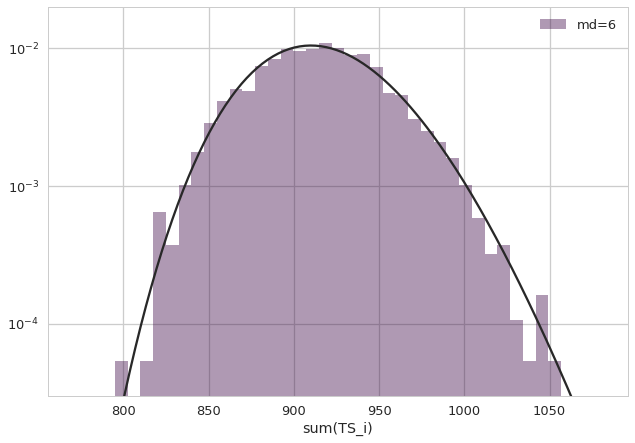

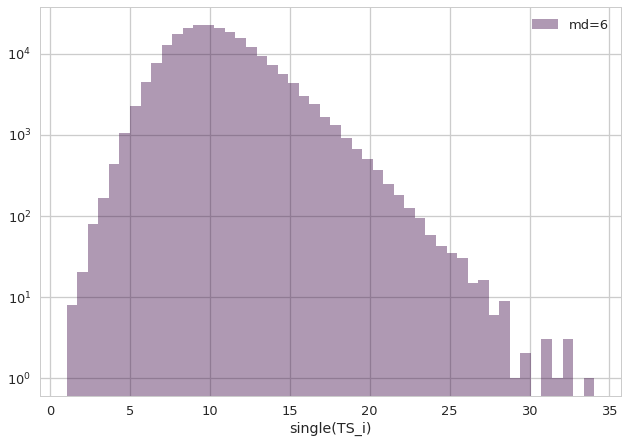

In [77]:
for md in bg_TS:
    plt.figure(1)
    sns.distplot(bg_TS[md]["TS"].sum(axis=1), kde=False, label="md={}".format(md), fit=chi2)
    plt.ylim(3e-5, 2e-2)
    plt.semilogy()
    plt.xlabel(r"sum(TS_i)")
    plt.legend()


    plt.figure(2)
    sns.distplot(bg_TS[md]["TS"].flatten(), kde=False, label="md={}".format(md))
    plt.xlabel(r"single(TS_i)")
    plt.semilogy()
    plt.legend()
        

/home/lschumacher/public_html/uhecr_stacking/hotspot_fit/merged/TS/ic-ant-scan_md-6_fitted-gamma_background.png


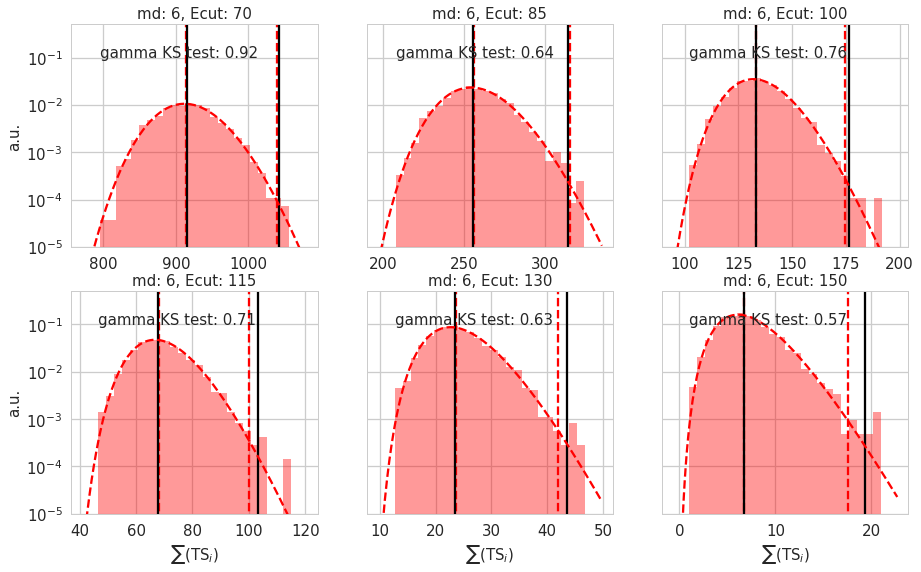

In [79]:
tw = 12
fontsize = 15
rcParams = dict()
rcParams["figure.figsize"] = (5*3,3*3)
rcParams["font.size"] = fontsize
rcParams["axes.labelsize"] = fontsize
rcParams["axes.titlesize"] = fontsize
rcParams["xtick.labelsize"] = fontsize
rcParams["ytick.labelsize"] = fontsize
mpl.rcParams.update(rcParams)

bg_quantiles = [erfc(0.)*0.5, erfc(3./np.sqrt(2))*0.5]
mdparams = [3, 6]
ecuts = [70, 85, 100, 115, 130, 150]
bins = 20
dim = (2,3)
norm = True
saveplots = True


for md in bg_TS:
    fcounter = 0
    if len(bg_TS[md])==0: continue
    fig, ax = plt.subplots(nrows=dim[0], ncols=dim[1], sharey=True)
    ax = ax.flatten()
    for ecut in ecuts:
        #plt.figure(fcounter)
        
        valid = bg_TS[md]["cr_e_inj"]>=ecut
        best_bg = np.where(valid, bg_TS[md]['TS'], np.zeros_like(bg_TS[md]['TS'])).sum(axis=-1)
        
        fitfunc=scipy.stats.gamma
        #fitfunc=scipy.stats.chi2
        fit = fitfunc.fit(best_bg)
        bg_fit_vals = fitfunc.isf(bg_quantiles, *fit)
        bg_trial_vals = [np.percentile(best_bg, 100*(1-b_q)) for b_q in bg_quantiles]
        
        
        bins = np.linspace(min(best_bg), max(best_bg), num=25)
        sns.distplot(best_bg, bins=bins, ax=ax[fcounter],kde=False, fit=fitfunc, label="{} trials".format(len(best_bg)), 
                     color="red",
                     fit_kws=dict(markersize=0, label="{} KS test: {:1.4f}".format(fitfunc.__dict__['name'], 
                                                                 scipy.stats.kstest(best_bg, fitfunc.cdf, args=fit)[1]), 
                                  color="red", linestyle="--"))
        if True:
            for bg_fit_val,bg_trial_val in zip(bg_fit_vals,bg_trial_vals):
                ax[fcounter].vlines(bg_fit_val, 1e-8, 1, color="red", linestyles="--")
                ax[fcounter].vlines(bg_trial_val, 1e-8, 1, color="black")
                #"""
            
        ax[fcounter].set_title(r"md: {}, Ecut: {}".format(md, ecut))
        ax[fcounter].semilogy(nonposy='clip')
        ax[fcounter].set_ylim(1e-5, 5e-1)
        #ax[fcounter].legend(loc=1)
        ax[fcounter].text(bins[0], 1e-1, s="{} KS test: {:1.2f}".format(fitfunc.__dict__['name'], 
                                                                 scipy.stats.kstest(best_bg, fitfunc.cdf, args=fit)[1]))
        fcounter += 1
    [axi.set_xlabel(r"$\sum(\mathrm{TS}_i)$") for i,axi in enumerate(ax) if i>=(dim[1]*(dim[0]-1))]
    [axi.set_ylabel(r"a.u.") for i,axi in enumerate(ax) if i%dim[1]==0]

    plt.savefig(os.path.join(figurepath, "TS", "{}_md-{}_fitted-gamma_background.png".format(identifier, md)))
    print os.path.join(figurepath, "TS", "{}_md-{}_fitted-gamma_background.png".format(identifier, md))
#plt.show()

## Signal only

In [21]:
import traceback

mu injected:  2.0
minimal TS:  1.3488900449091838
4


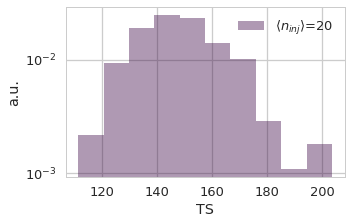

mu injected:  4.0
minimal TS:  1.7392496779465225
5


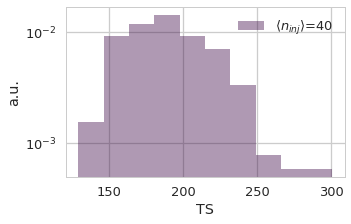

mu injected:  6.0
minimal TS:  1.949200727811247
6


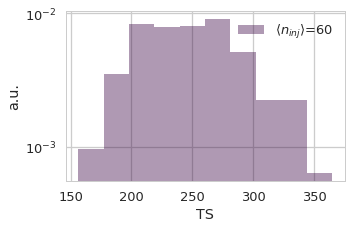

mu injected:  2.0
minimal TS:  2.0128138623244225
7


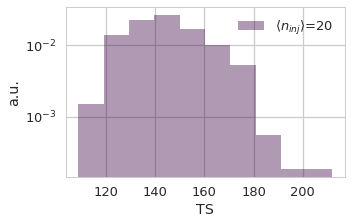

mu injected:  3.0
minimal TS:  1.0993486650826254
8


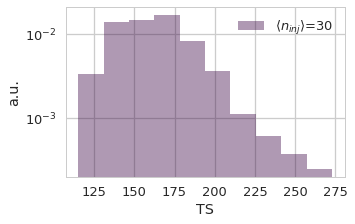

mu injected:  4.0
minimal TS:  0.9316446181889895
9


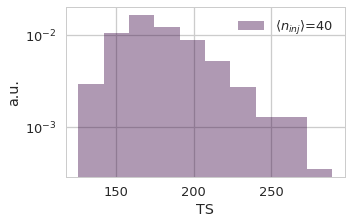

mu injected:  2.0
minimal TS:  0.9499496195050583
10


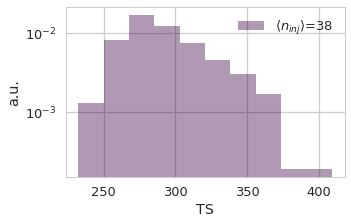

mu injected:  4.0
minimal TS:  1.8783322674529472
11


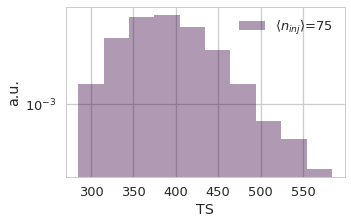

mu injected:  6.0
minimal TS:  1.7622042841539418
12


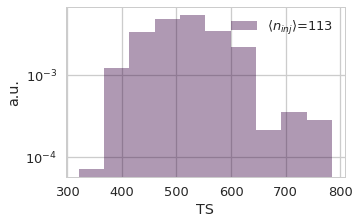

mu injected:  2.0
minimal TS:  1.4504233917951028
13


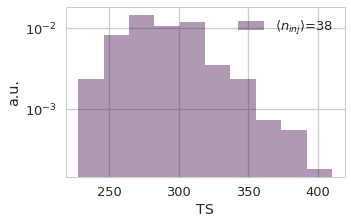

mu injected:  3.0
minimal TS:  0.5302290551586042
14


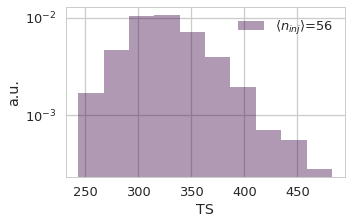

mu injected:  4.0
minimal TS:  1.6998450417212672
15


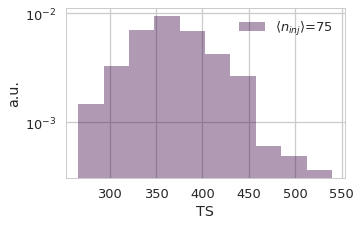

mu injected:  1.0
minimal TS:  1.2853166467372583
16


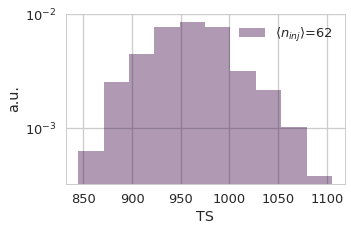

mu injected:  2.0
minimal TS:  1.723420098905669
17


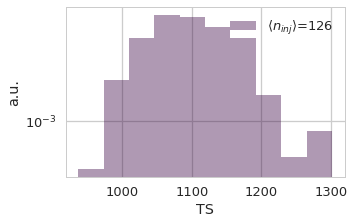

mu injected:  4.0
minimal TS:  1.9643607991883014
18


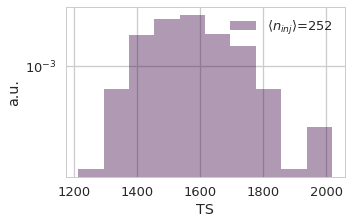

mu injected:  1.0
minimal TS:  0.0
19


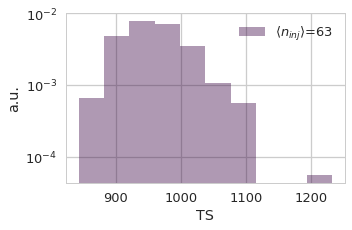

mu injected:  2.0
minimal TS:  2.2013417702469313
20


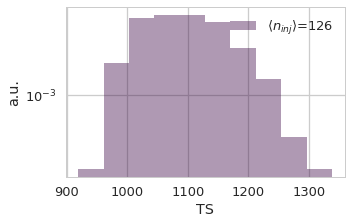

mu injected:  4.0
minimal TS:  1.6152468719001964
21


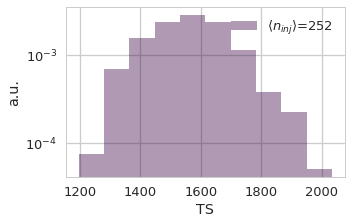

In [25]:
## With different cuts on E
## Sensitivity and disc pot
#"""
tw=5
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw / 1.6)
rcParams["font.size"] = 20
mpl.rcParams.update(rcParams)

#"""
bg_quantiles = [erfc(0.)*0.5, erfc(3./np.sqrt(2))*0.5] 
s_quantiles = [0.1, 0.5] 
labels=["Sens.", r"3$\sigma$ disc."] 
save_labels=["sens", r"disc3"] 
plotting = True
saveplots = False

remove_keys = []

figure_counter = 3
for md in sig_TS:
    for ecut in sig_TS[md]:
        for s in sig_TS[md][ecut]:
            for i,mu in enumerate(sig_TS[md][ecut][s]):
                bins = 10
                try:
                    print "mu injected: ", mu
                    print "minimal TS: ", sig_TS[md][ecut][s][mu]["data"]['TS'].min()
                    best = sig_TS[md][ecut][s][mu]["data"]['TS'].sum(axis=-1)

                    if plotting:
                        plt.figure(figure_counter)
                        figure_counter+=1
                        sns.distplot(best, bins=bins, rug=False, kde=False, 
                                    hist_kws=dict(normed=True),
                                    label=r"$\langle n_{{inj}} \rangle $={:1.0f}".format(
                                        np.mean(sig_TS[md][ecut][s][mu]["data"]['nsources_inj'].sum(axis=-1))))

                        plt.legend(loc=1)
                        #plt.ylim(1e-6,1)
                        plt.xlabel("TS")
                        plt.ylabel("a.u.")
                        plt.semilogy(nonposy="clip")
                        if saveplots: plt.savefig(os.path.join(figurepath, 
                                                               str(figure_counter)+"_TS_distribution_signal.png"))
                        print figure_counter
                        plt.show()
                        #plotting = False

                except:
                    err, info, tb = sys.exc_info()
                    print "Something went wrong ...", info
                    traceback.print_exc()
                    print mu, s, ecut, md
                    print sig_TS[md][ecut][s][mu]


## Evaluate TS

In [158]:
## With different cuts on E
## Sensitivity and disc pot
#"""
tw=8
fontsize = 15
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw / 1.2)
rcParams["font.size"] = fontsize
rcParams["axes.labelsize"] = fontsize
rcParams["axes.titlesize"] = fontsize
rcParams["xtick.labelsize"] = fontsize
rcParams["ytick.labelsize"] = fontsize
mpl.rcParams.update(rcParams)
#"""
clen = len(utils.colors)
bg_quantiles = [erfc(0.)*0.5, erfc(3./np.sqrt(2))*0.5] 
s_quantiles = [0.1, 0.5] 
labels=["Sens.", r"3$\sigma$ disc."]
save_labels=["sens", r"disc3"]
final_flux = dict()
plotting = False
debug = False
saveplots = False

figure_counter = 3
for md in sig_TS:
    print "md: ", md
    final_flux[md] = dict()
    ecuts = np.sort(sig_TS[md].keys())
    for ecut in ecuts:
        print " * "*20
        print "ecut:", ecut
        final_flux[md][ecut] = dict()
        shifts = np.sort(sig_TS[md][ecut].keys())
        for s in shifts:
            print "shift:", s
            if not any(sig_TS[md][ecut][s]): continue

            final_flux[md][ecut][s] = dict()
            valid = bg_TS[md]["cr_e_inj"]>=ecut
            best_bg = np.where(valid, bg_TS[md]['TS'], np.zeros_like(bg_TS[md]['TS'])).sum(axis=-1)

            ## Evaluation of Test Statistic
            ## Use Percentiles, because most fits are unstable
            bins=10
            fitfunc = None
            bg_vals = [np.percentile(best_bg, 100*(1-b_q)) for b_q in bg_quantiles]
            sig_val = []
            for i,ak in enumerate(sig_TS[md][ecut][s]):
                #try:
                print "mu injected: ", ak
                #if np.ndim(sig_TS[md][ecut][s][ak]["data"]['TS']) > 1: 
                #print sig_TS[md][ecut][s][ak]["data"].dtype
                best = sig_TS[md][ecut][s][ak]["data"]['TS'].sum(axis=-1)
                """else:
                    best = sig_TS[md][ecut][s][ak]["data"]['TS']"""
                    
                to_append = [ak]
                to_append.extend([np.percentile(best, 100*s_q) for s_q in s_quantiles])
                to_append.extend([sig_TS[md][ecut][s][ak]["phi0"]])
                sig_val.append(to_append)
                if plotting==True:# or (md==6 and ecut==85):
                    plt.figure(figure_counter)
                    figure_counter+=1
                    sns.distplot(best, bins=bins, rug=False, kde=False, 
                                hist_kws=dict(normed=True, color=utils.colors[i%clen]), 
                                fit_kws=dict( color=utils.colors[i%clen]),
                                label=r"$\mu $={:1.0f}, {} trials".format(sig_val[-1][0], 
                                                                          len(sig_TS[md][ecut][s][ak]["data"])))

                    sns.distplot(best_bg, bins=bins*2, rug=False, kde=False, fit=fitfunc,
                                hist_kws=dict(normed=True, color="black"), 
                                fit_kws=dict( color="black", markersize=0),
                                label="B, {} trials".format(len(best_bg)))

                    for ii,(s_v, s_q) in enumerate(zip(sig_val[-1][1:-1], s_quantiles)):
                        #if ii==1: continue
                        plt.vlines(s_v, 0, 0.5, 
                                   color=utils.colors[i%clen], 
                                   label="{:1.1f} S at {:1.0f}".format(s_q, s_v),
                                   linestyle=utils.linestyles[ii]
                                  )
                    for ii,(b_q,bg_val) in enumerate(zip(bg_quantiles, bg_vals)):
                        #if ii==1: continue
                        if b_q <0.01:
                            b_label="{:1.1e} B at {:1.0f}".format(b_q, bg_val)
                        else:
                            b_label="{:1.1f} B at {:1.0f}".format(b_q, bg_val)
                        plt.vlines(bg_val, 0, 0.5, 
                                   color="black", 
                                   label=b_label,
                                   linestyle=utils.linestyles[ii]
                                  )
                    plt.legend(loc=2, ncol=2)
                    plt.ylim(5e-5,5e-1)
                    plt.xlabel("TS")
                    plt.ylabel("a.u.")
                    plt.semilogy(nonposy="clip")
                    if saveplots:# or (md==6 and ecut==85): 
                        plt.savefig(os.path.join(figurepath, "{}_md-{}_ecut-{}_ninj-{}_fitted-gamma_background.png".format(identifier, md, ecut, ak)))
                    plt.show()

            for qq,(b_q,s_q) in enumerate(zip(bg_quantiles, s_quantiles)):

                temp = np.array(sig_val).T
                mu = temp[0] # raw max number of source events
                ts = temp[1+qq]
                mu_space = np.linspace(min(mu), max(mu))
                vals = np.polyfit(mu, ts, 1) #2)
                fit = np.poly1d(vals)


                if debug:
                    plt.figure(figure_counter)
                    figure_counter += 1
                    plt.plot(mu, ts, marker="o", label="Raw Significances", lw=0)
                    plt.plot(mu_space, fit(mu_space), linestyle="--", label="Significances fit", markersize=0)
                    plt.hlines(bg_vals[qq], min(mu), max(mu))

                vals[-1] -= bg_vals[qq]
                roots = np.roots(vals)
                roots = min(roots) #[roots>min(mu)])
                if debug:
                    print "roots:", roots
                    plt.vlines(roots, min(ts), max(ts), 
                               label=labels[qq]+" crossing point at mu={:1.0f}".format(roots)) #roots[roots>min(mu)][0]
                    plt.legend(loc=1)
                    plt.xlabel("Sum of injected signal events")
                    plt.ylabel("TS")
                    if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_mu_crossing_fitted-gamma.png"))
                    print figure_counter
                    plt.show()
                    temp = np.array(sig_val).T
                    
                mu = temp[-1] # flux
                ts = temp[1+qq]
                mu_space = np.linspace(min(mu), max(mu))
                vals = np.polyfit(mu, ts, 1) #2)
                fit = np.poly1d(vals)


                if debug:
                    plt.figure(figure_counter)
                    figure_counter += 1
                    plt.plot(mu, ts, marker="o", label="Raw Significances", lw=0)
                    plt.plot(mu_space, fit(mu_space), linestyle="--", label="Significances fit", markersize=0)
                    plt.hlines(bg_vals[qq], min(mu), max(mu))

                vals[-1] -= bg_vals[qq]
                roots = np.roots(vals)
                roots = min(roots) #[roots>min(mu)])
                final_flux[md][ecut][s][save_labels[qq]] = roots
                print save_labels[qq], final_flux[md][ecut][s][save_labels[qq]]
                if debug:
                    print "roots:", roots
                                   
                    plt.vlines(roots, min(ts), max(ts), 
                               label=labels[qq]+" crossing point at phi0={:1.2e}".format(roots)) #roots[roots>min(mu)][0]
                    plt.legend(loc=1)
                    plt.xlabel("Sum of source fluxes")
                    plt.ylabel("TS")
                    if saveplots: plt.savefig(os.path.join(figurepath, str(figure_counter)+save_labels[qq]+"_phi0_crossing_fitted-gamma.png"))
                    print figure_counter
                    plt.show()
                    

md:  6.0
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
ecut: 70.0
shift: 0.0
mu injected:  1.0
mu injected:  2.0
mu injected:  4.0
sens 6.281651820177348e-09
disc3 1.5010629655968095e-08
shift: 5.0
mu injected:  1.0
mu injected:  2.0
mu injected:  4.0
sens 6.97567128329118e-09
disc3 1.553755454592884e-08
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
ecut: 85.0
shift: 0.0
mu injected:  2.0
mu injected:  3.0
mu injected:  5.0
sens 9.168981355156105e-09
disc3 1.856539378633952e-08
shift: 5.0
mu injected:  2.0
mu injected:  3.0
mu injected:  5.0
sens 1.3093221233743218e-08
disc3 2.27049125092174e-08
 *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  *  * 
ecut: 100.0
shift: 0.0
mu injected:  3.0
mu injected:  4.0
mu injected:  6.0
sens 1.534443699869258e-08
disc3 2.336455122281633e-08
shift: 5.0
mu injected:  3.0
mu injected:  4.0
mu injected:  6.0
sens 1.740948710072776e-08
disc3 2.6899335920461617e-08


In [159]:
name = "{}_{}_final-flux.pickle".format(current_time, identifier)
with open(os.path.join(savepath, name), "wb") as f:
    pickle.dump(final_flux, f, protocol=2)

## Plotting flux per source

In [143]:
savepath

'/data/user/lschumacher/projects/stacking/hotspot_fitting/merged'

In [19]:
with open('/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1531400598_svn_final-flux.pickle', "rb") as f:
    final_flux = pickle.load(f)
identifier = "svn"
plot1_ylim = (-8.3, -7.3)
plot2_ylim = (0.0, 0.55)

In [21]:
with open('/data/user/lschumacher/projects/stacking/hotspot_fitting/merged/1531140539_ic-ant-scan_final-flux.pickle', "rb") as f:
    final_flux = pickle.load(f)
identifier = "ic-ant-scan"
plot1_ylim = (-8.9, -8.1)
plot2_ylim = (0.0, 0.35)

[0.0, 5.0]


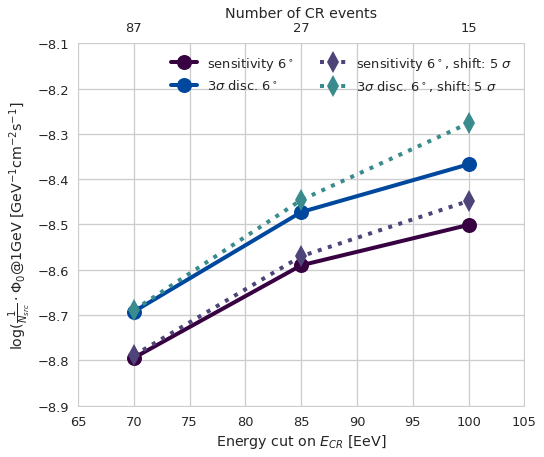

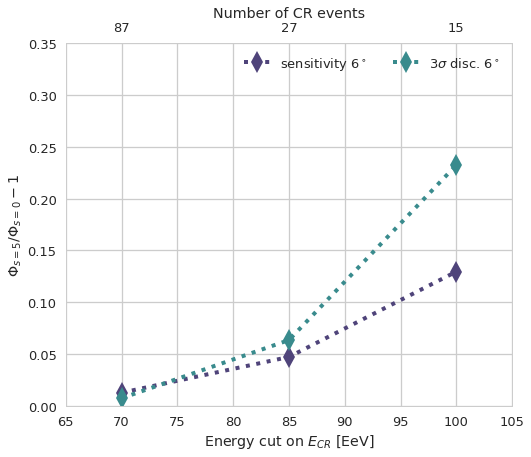

In [22]:
#"""
tw=8
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/1.2)
mpl.rcParams.update(rcParams)
#"""
lw1 = 2.
lw2 = 4.
saveplots = True


fig1, ax1 = plt.subplots()
figr, axr = plt.subplots()
labels=["sensitivity", r"3$\sigma$ disc."]
base_styles = dict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="-", color=utils.colors[0]),
              disc3=dict(lw=lw2, markersize=15, marker="o", linestyle="-", color=utils.colors[1]),
              disc5=dict(lw=lw2, markersize=15, marker="o", linestyle="-", color=utils.colors[2])
             )
proj_styles = dict(sens=dict(lw=lw2, markersize=15, marker="d", linestyle=":", color=utils.light_colors[0]),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":", color=utils.light_colors[1]),
              disc5=dict(lw=lw2, markersize=15, marker="d", linestyle=":", color=utils.light_colors[2])
             )
md_labels = [r" $6^\circ$"] #[r" $3^\circ$", r" $6^\circ$"]

for i,md in enumerate(final_flux):
    ecuts = sorted(final_flux[md])
    erange = (min(ecuts)-5, max(ecuts)+5)
    #for ecut in final_flux[md]:
    shift = sorted(final_flux[md][ecuts[0]])
    print shift
    for s in shift:
        if s==0.:
            #continue
            styles=base_styles
            add = ""
        else:
            styles=proj_styles
            add = r", shift: {} $\sigma$".format(int(s))
        for j,level in enumerate(final_flux[md][ecuts[0]][s]):
            ax1.plot(ecuts, 
                     np.log10([final_flux[md][ecut][s][level] for ecut in ecuts]), 
                     label=labels[j]+md_labels[i]+add,
                     **styles[level]
                    )
    if len(shift)>1:
        for j,level in enumerate(final_flux[md][ecuts[0]][0]):
            axr.plot(ecuts, 
                     np.array([final_flux[md][ecut][max(shift)][level] for ecut in ecuts])\
                     /np.array([final_flux[md][ecut][min(shift)][level] for ecut in ecuts])-1., 
                     label=labels[j]+md_labels[i],
                     **styles[level]
                    )
            
ax1.set_xlim(erange)
ax1.set_ylim(plot1_ylim)
ax1.grid(True)
ax1.set_xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
ax1.set_ylabel(r"$ \log (\frac{1}{N_{src}} \cdot \Phi_0 @ 1\mathrm{GeV}\; [\mathrm{GeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}]$") #Threshold flux in 
ax1.legend(ncol=2, loc=1)
#ax1.text(85, -7.7, r"Flux per source performance")

ax2 = ax1.twiny()
ax2.set_xlabel("Number of CR events")
ax2.set_xlim(erange)
ax2.set_xticks(ticks=ecuts)
ax2.set_xticklabels(labels=[n_cr[e] for e in ecuts])
ax2.grid(False)
fig1.savefig(os.path.join(figurepath, "performance", "{}_flux_comparison_fitted_gamma.png".format(identifier)))

if len(shift)>1:
    axr.set_xlim(erange)
    axr.set_ylim(plot2_ylim)
    axr.grid(True)
    axr.set_xlabel(r"Energy cut on $E_{CR} \;[\mathrm{EeV}] $")
    axr.set_ylabel(r"$\Phi_{s=5}/\Phi_{s=0}-1$") #Threshold flux in 
    axr.legend(ncol=2, loc=1)
    #axr.text(67, 0.27, r"Flux per source performance comparison with/out shift")
    #axr.text(67, 0.45, r"Flux per source performance comparison with/out shift")

    axr2 = axr.twiny()
    axr2.set_xlabel("Number of CR events")
    axr2.set_xlim(erange)
    axr2.set_xticks(ticks=ecuts)
    axr2.set_xticklabels(labels=[n_cr[e] for e in ecuts])
    axr2.grid(False)
    figr.savefig(os.path.join(figurepath, "performance", "{}_relative_shift_comparison_fitted_gamma.png".format(identifier)))

## angular distance true vs fit

In [63]:
from ic_utils import angular_distance_matrix, angular_distance

import pandas as pd

In [105]:
distance_cut = 0.5
bins = 80
range = (0,40)
fcounter = 0
new=True
for md in sig_TS:
    ecuts = np.sort(sig_TS[md].keys())
    for ecut in ecuts:
        shifts = np.sort(sig_TS[md][ecut].keys())
        for s in shifts:
            if not any(sig_TS[md][ecut][s]): continue
            for i,ak in enumerate(sig_TS[md][ecut][s]):
            
                nsig = np.array(sig_TS[md][ecut][s][ak]["data"])
                ind_sources = []
                for nd,nr in zip(nsig['dec'], nsig['ra']):
                    nd = np.array(nd, dtype=np.complex64)
                    nd.imag = nr
                    ind_sources.append(len(np.unique(np.round(nd, decimals=2))))
                ind_sources = np.array(ind_sources)
                # Calculate distance from one hotspot to the matching injected source
                distance = np.degrees(angular_distance([nsig['dec'], nsig['ra']],
                                                       [nsig['dec_inj'], nsig['ra_inj']])).flatten()

                # Count as "correct" if distance is smaller than distance_cut (e.g. 0.5deg)
                # This way we see which injected sources have actually been found
                # Normalize to total number of hotspots
                n1 = np.count_nonzero(distance<=distance_cut)*1./len(distance)

                # Calculate distance from all hotspots to all other injected sources
                # Then, find the minimum distance for each
                # This way, we see also hotspots that have been fitted multiple times
                if nsig['dec'].ndim>1:
                    distance = np.degrees(angular_distance_matrix(nsig['dec'], 
                                                                   nsig['ra'],
                                                                   nsig['dec_inj'], 
                                                                   nsig['ra_inj']))
                    distance = np.min(distance, axis=-1).flatten()
                n2 = np.count_nonzero(distance<=distance_cut)*1./len(distance)

                if new:
                    frame = pd.DataFrame({
                        "md": md, 
                        "shifts": s, 
                        "ecut": ecut, 
                        "ind_sources": ind_sources, 
                        "ncr": n_cr[ecut], 
                        "nsources_inj": nsig["nsources_inj"].sum(axis=-1),
                        "nsources": nsig["nsources"].sum(axis=-1),
                        "mu": ak,
                        "dir_match": n1,
                        "ov_match": n2,
                        "ov-dir": n2-n1,
                        #"ov/dir-1": (n2-n1)*1./n1,
                    })
                    new = False
                else:
                    frame = frame.append(pd.DataFrame({
                        "md": md, 
                        "shifts": s,
                        "ecut": ecut, 
                        "ind_sources": ind_sources, 
                        "ncr": n_cr[ecut], 
                        "nsources_inj": nsig["nsources_inj"].sum(axis=-1),
                        "nsources": nsig["nsources"].sum(axis=-1),
                        "mu": ak,
                        "dir_match": n1,
                        "ov_match": n2,
                        "ov-dir": n2-n1,
                        #"ov/dir-1": (n2-n1)*1./n1,
                    }), ignore_index=True)

print "done" 
frame["ncr-ind_sources"] = frame.ncr-frame.ind_sources

done


In [104]:
len(frame)

6551

In [103]:
frame.ind_sources.unique()

array([60, 63, 57, 61, 56, 59, 58, 65, 55, 62, 53, 66, 67, 64, 54, 50, 68,
       69, 52, 49, 51, 48, 47, 24, 22, 21, 23, 26, 25, 20, 19, 14, 15, 13,
       12])

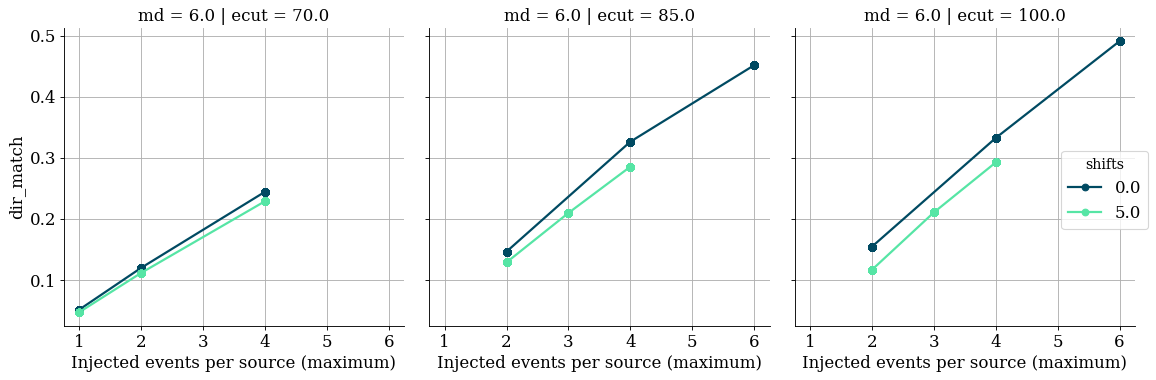

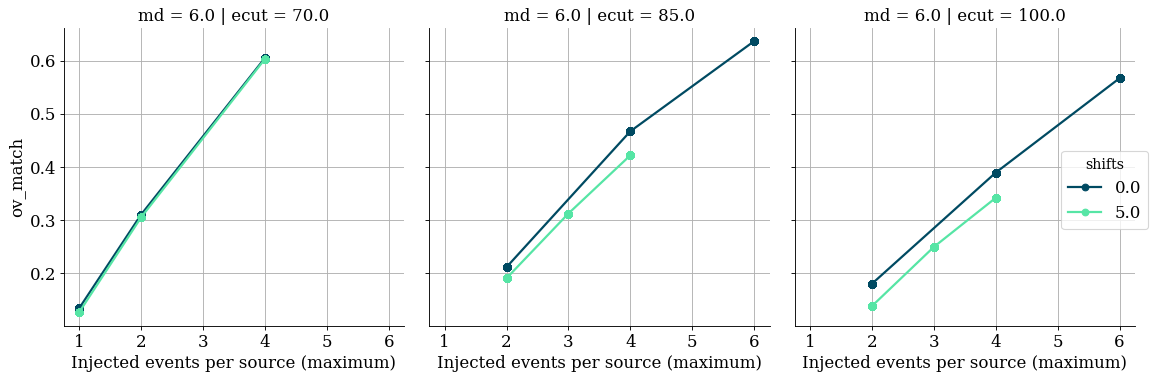

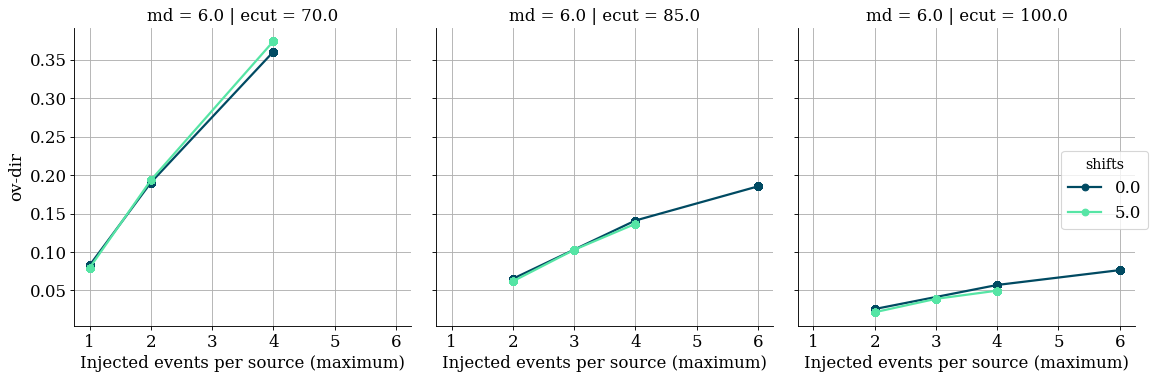

In [74]:
colors = sns.cubehelix_palette(2, start=1.5, rot=1.75, dark=0.2, light=0.7, reverse=True, hue=2)
size = 5
aspect = 0.9
keys = ["dir_match", "ov_match", "ov-dir"]
save_keys = ["direct_match", "overall_match", "diff_match"]
for k,sk in zip(keys, save_keys):
    grid = sns.FacetGrid(frame, row="md", hue="shifts", col="ecut", size=size, aspect=aspect, palette=colors) #hue="ecut", 
    grid = grid.map(plt.plot, "mu", k, marker="o")
    grid.add_legend(ncol=1)
    grid.set_xlabels("Injected events per source (maximum)")
    [ax.grid(True) for ax in grid.axes[0]]
    grid.savefig(os.path.join(figurepath, "HSP_eval", "{}_HSP_{}.png".format(identifier, sk)))

## here

In [129]:
tmp_mu

[]

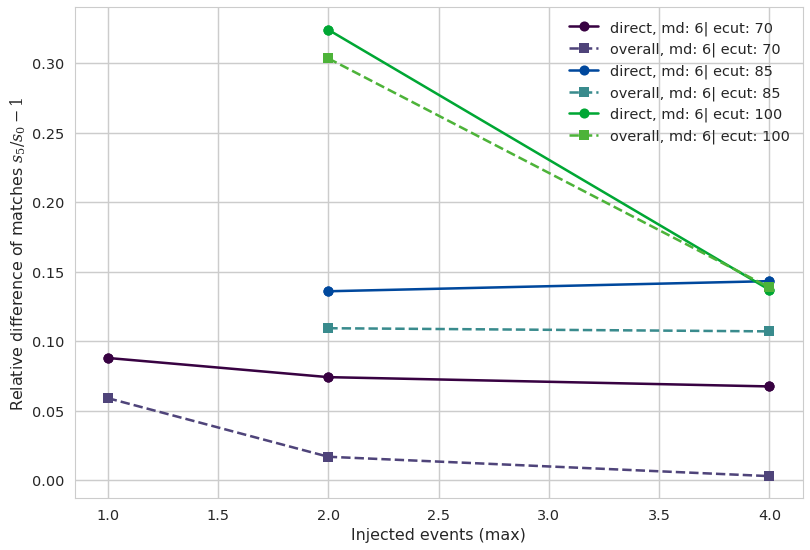

In [137]:
sns.set()
sns.set_context("talk")
sns.set_style("whitegrid")
i=0
for md in frame.md.unique():
    tempframe = frame[frame.md==md]
    for ecut in tempframe.ecut.unique():
        temp = tempframe[tempframe.ecut==ecut]
        tmp_mu = []
        tmp_diff = []
        ov_tmp_mu = []
        ov_tmp_diff = []
        for mu in temp.mu.unique():
            try:
                tmp = temp[temp.mu==mu]
                dir_match_difference = tmp[tmp.shifts==0].dir_match.unique()/tmp[tmp.shifts==5].dir_match.unique() -1.
                
                plt.plot(mu, 
                         np.unique(dir_match_difference), 
                         marker="o", 
                         linestyle="-",
                         color=utils.colors[i],
                         #label="dir, md: {}| ecut: {}".format(md, ecut)
                        )
                tmp_mu.append(mu)
                tmp_diff.extend(dir_match_difference)
            except:
                continue
            try:
                tmp = temp[temp.mu==mu]
                ov_match_difference = tmp[tmp.shifts==0].ov_match.unique()/tmp[tmp.shifts==5].ov_match.unique() -1.
                plt.plot(mu, 
                         np.unique(ov_match_difference), 
                         marker="s", 
                         linestyle="--",
                         color=utils.light_colors[i],
                         #label="ov, md: {}| ecut: {}".format(md, ecut)
                        )
                ov_tmp_mu.append(mu)
                ov_tmp_diff.extend(ov_match_difference)
            except:
                continue
        plt.plot(tmp_mu, 
                 tmp_diff, 
                 marker="o", 
                 linestyle="-",
                 color=utils.colors[i],
                 label="direct, md: {}| ecut: {}".format(int(md), int(ecut)))
        plt.plot(ov_tmp_mu, 
                 ov_tmp_diff, 
                 marker="s", 
                 linestyle="--",
                 color=utils.light_colors[i],
                 label="overall, md: {}| ecut: {}".format(int(md), int(ecut)))
        i += 1
        i = i%4

plt.legend()
plt.grid(True)
plt.xlabel("Injected events (max)")
plt.ylabel("Relative difference of matches $s_5/s_0 -1$")
plt.savefig(os.path.join(figurepath, "HSP_eval", "{}_HSP_match-difference.png".format(identifier)))

<Figure size 576x480 with 0 Axes>

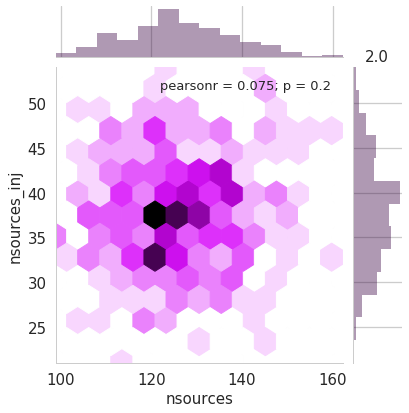

<Figure size 576x480 with 0 Axes>

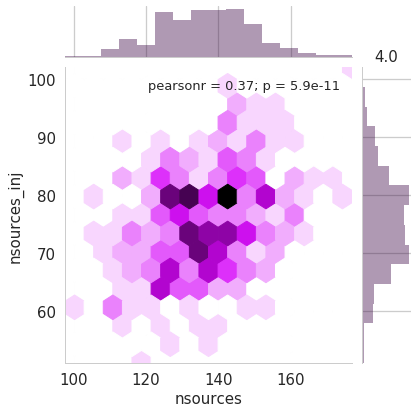

<Figure size 576x480 with 0 Axes>

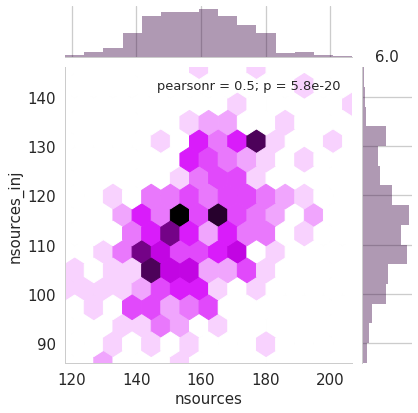

In [68]:
tempframe = frame[frame.md==6]
tempframe = tempframe[tempframe.ecut==85]
tempframe = tempframe[tempframe.shifts==0]
for mu in tempframe.mu.unique():
    temp = tempframe[tempframe.mu==mu]
    plt.figure()
    sns.jointplot(x="nsources", y="nsources_inj", data=temp, kind="hex")
    plt.title(mu)

/home/lschumacher/my_virtualenvs/my_skylab/lib/python2.7/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


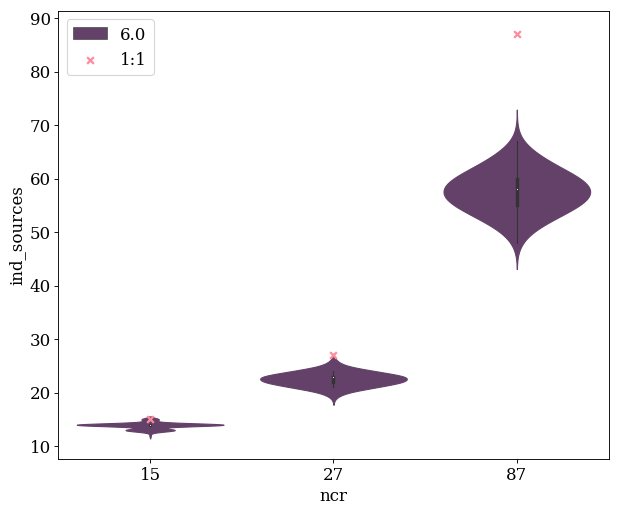

In [69]:
plt = utils.plain_plotting()

ax = sns.violinplot(x=frame.ncr, y=frame.ind_sources, hue=frame.md, bw=0.5, inner="box", linewidth=1, palette=utils.light_colors)
x = ax.get_xticks()
y = [int(a.get_text()) for a in ax.get_xticklabels()]
ax.scatter(x, y, color=utils.light_colors[-1], label="1:1", marker="x")
ax.legend(loc=2)
ax.figure.savefig(os.path.join(figurepath, "HSP_eval", "{}_HSP_distinct_sources.png".format(identifier)))


## Skymaps

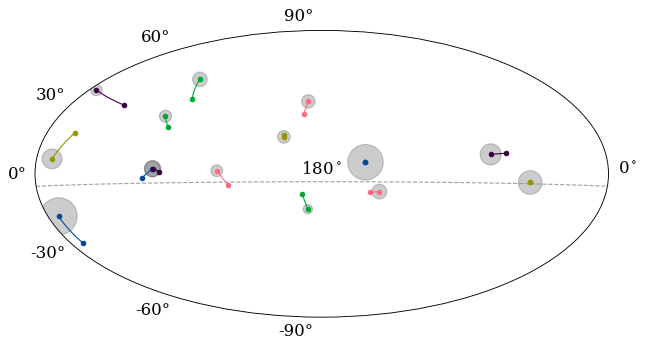

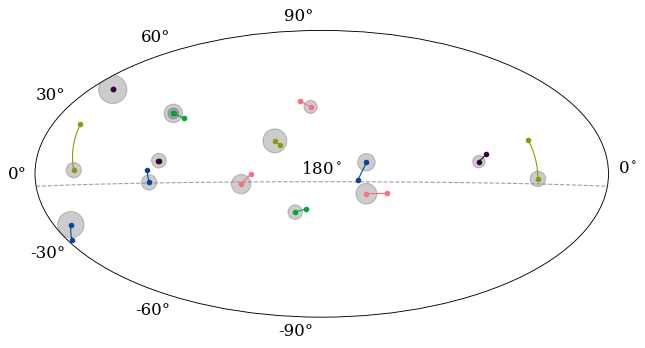

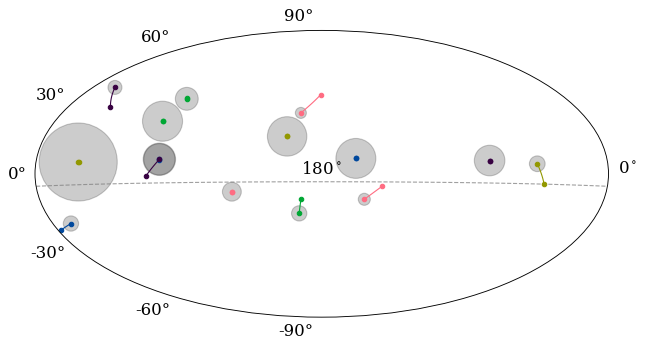

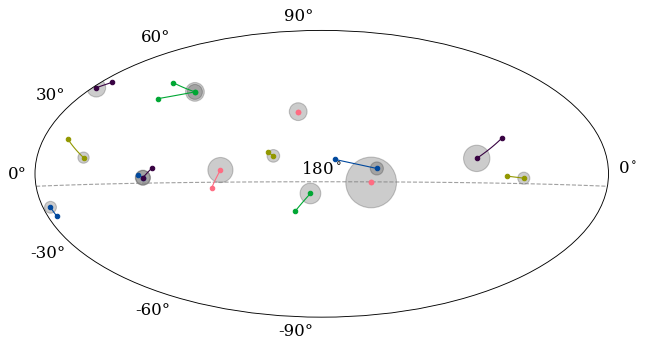

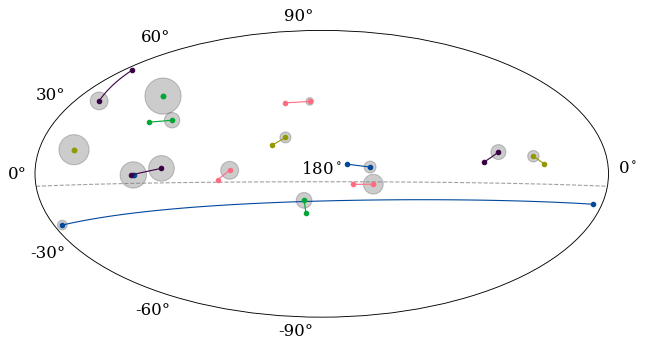

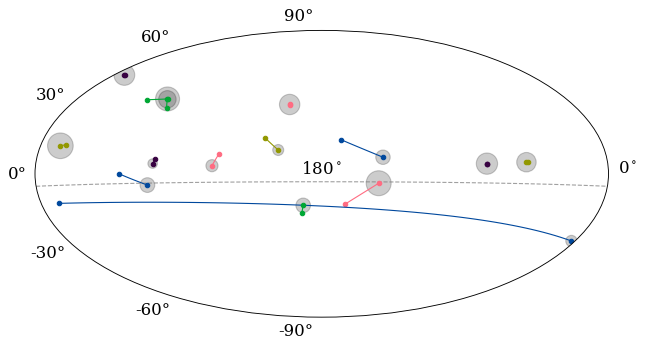

In [323]:
c=0
for md in sig_TS:   
    for ecut in sig_TS[md]:
        for s in sig_TS[md][ecut]:
            for i,ak in enumerate(sig_TS[md][ecut][s]):
                fig, ax = utils.simple_skymap(plt)
                sig = np.array(sig_TS[md][ecut][s][ak]["data"])
                ax.plot([np.pi-sig['ra'][c].flatten(), np.pi-sig['ra_inj'][c].flatten()], 
                         [sig['dec'][c].flatten(), sig['dec_inj'][c].flatten()],
                         marker="o", ls="-", lw=1, markersize=4
                        )
                ax.scatter(np.pi-sig['ra'][c].flatten(), 
                        sig['dec'][c].flatten(),
                        marker="o", s=sig['TS'][c].flatten()**2*2, color="black", alpha=0.2
                       )

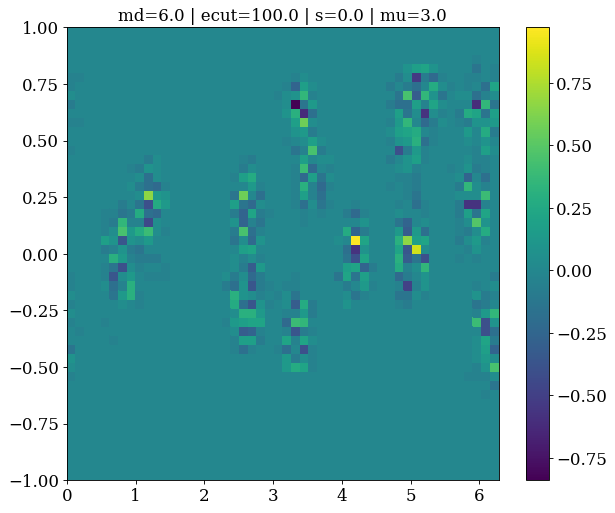

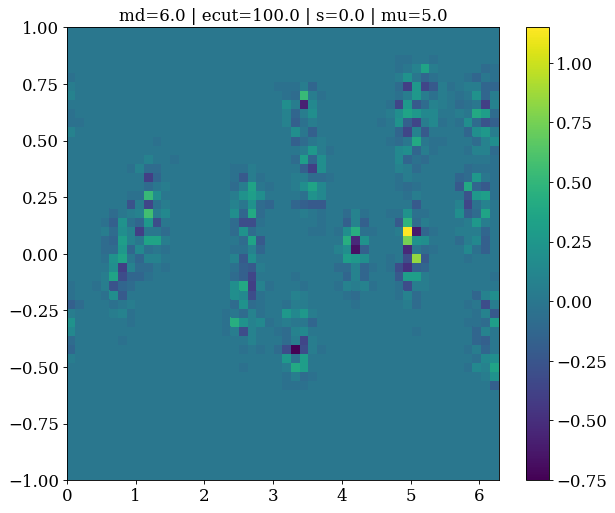

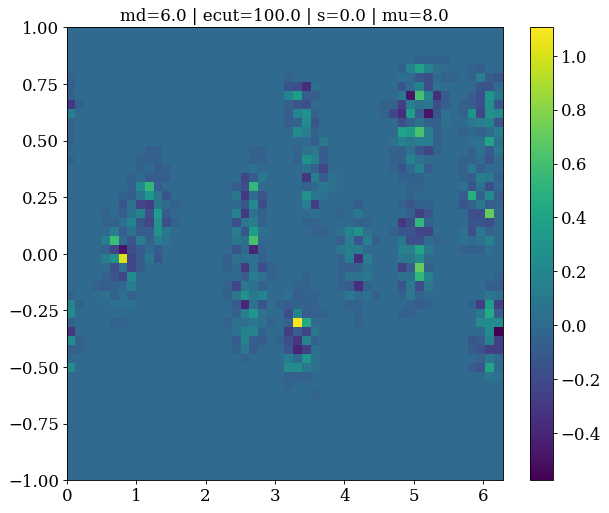

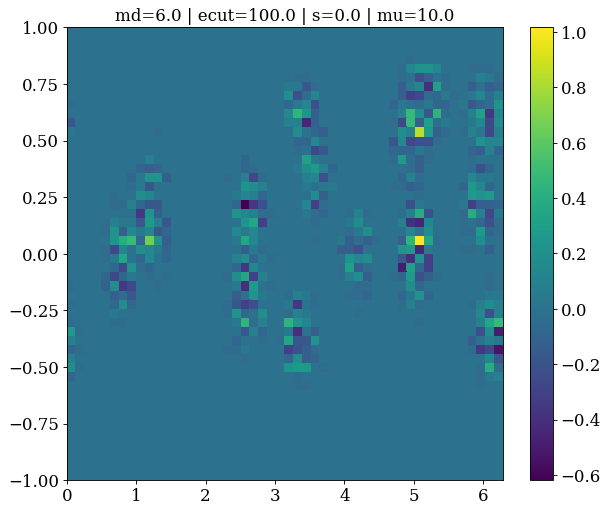

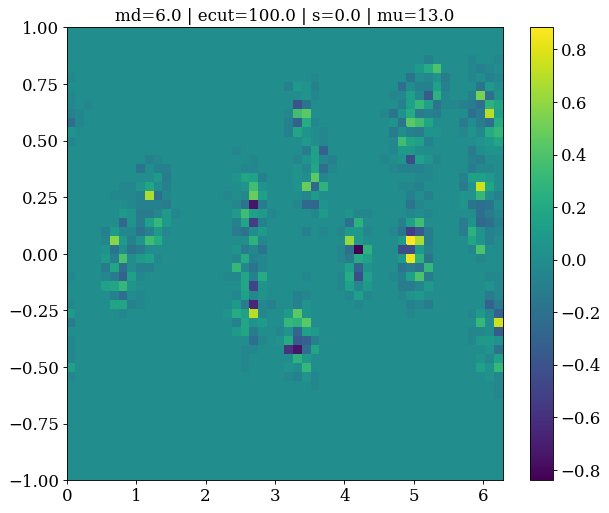

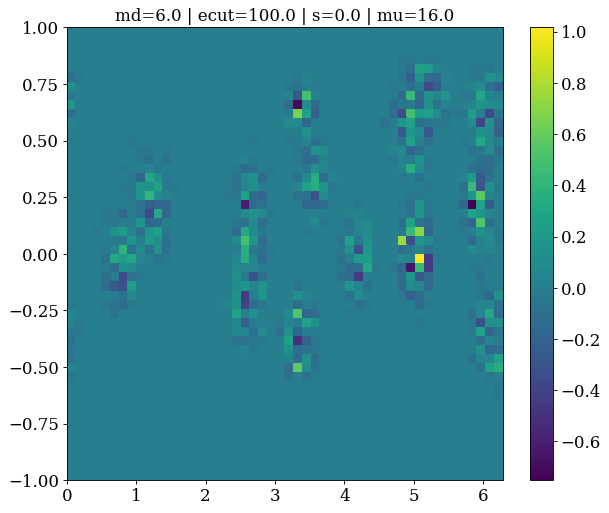

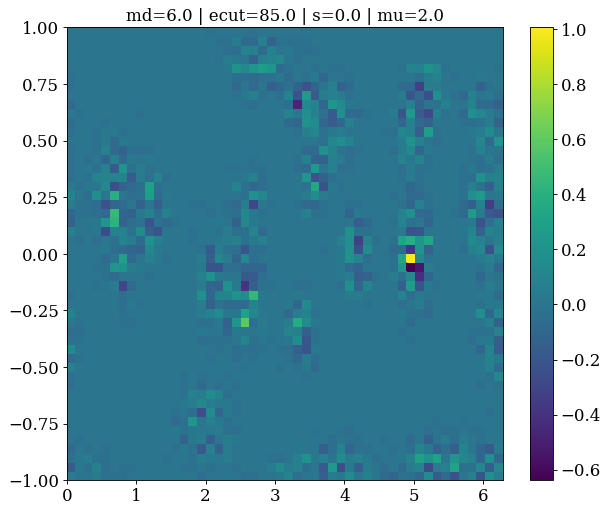

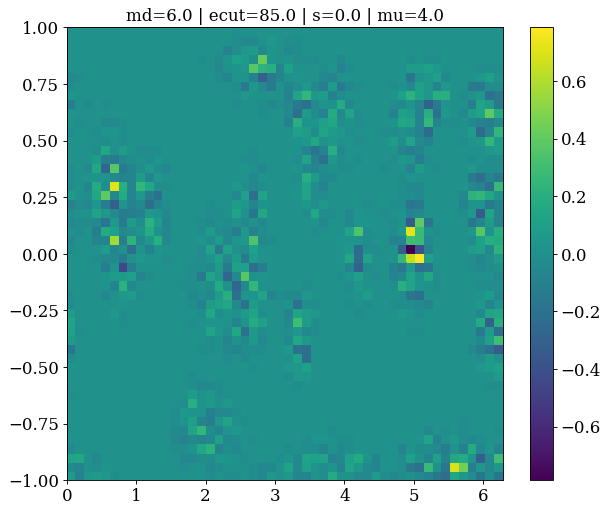

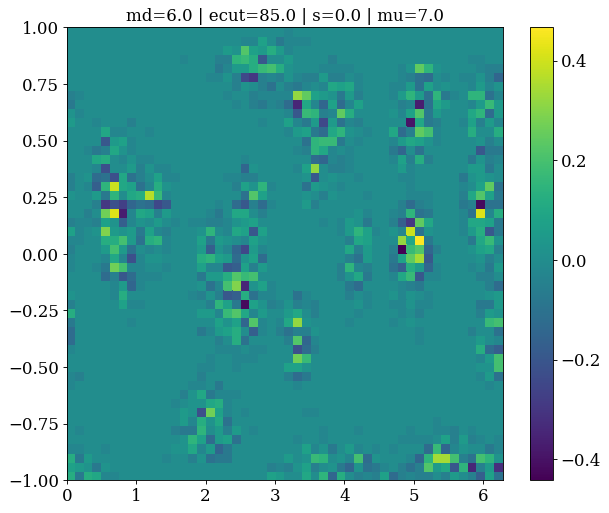

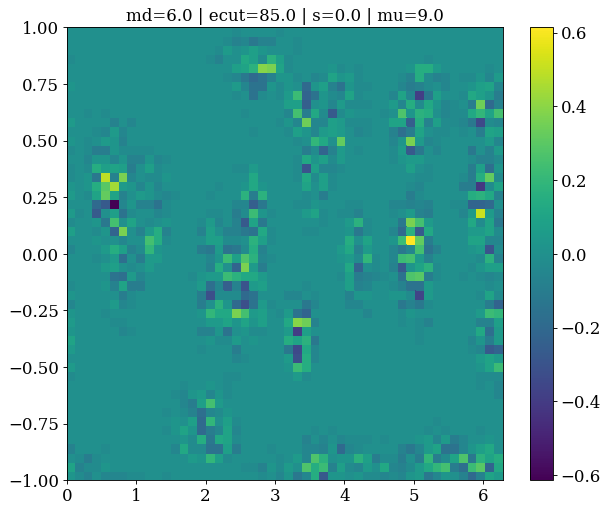

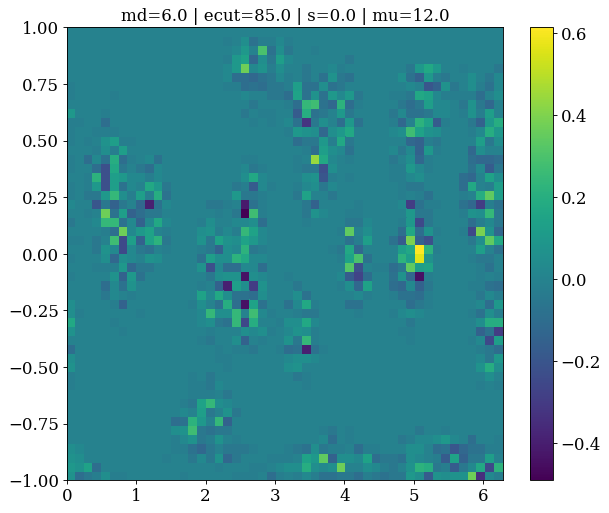

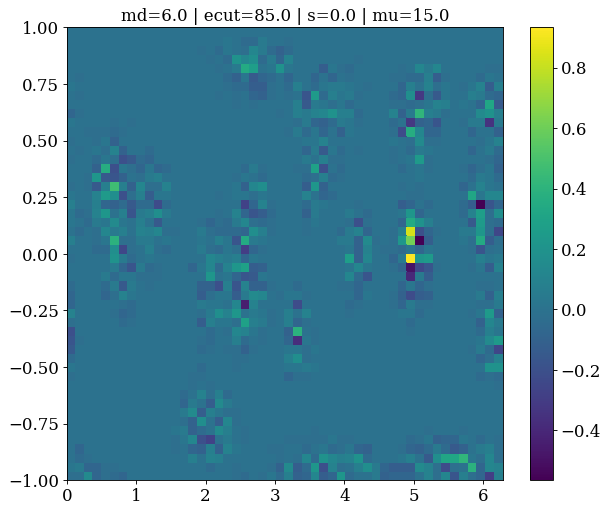

In [81]:
for md in sig_TS:   
    for ecut in sig_TS[md]:
        for s in sig_TS[md][ecut]:
            for i,ak in enumerate(sig_TS[md][ecut][s]):
                sig = np.array(sig_TS[md][ecut][s][ak]["data"])
                plt.figure()
                plt.title("md={} | ecut={} | s={} | mu={}".format(md, ecut, s, ak))
                H_inj, xed, yed= np.histogram2d(np.sin(sig['dec_inj'].flatten()), 
                                            sig['ra_inj'].flatten(), 
                                            range=[[-1, 1], [0, 2*np.pi]], 
                                            bins=50,
                                            normed=True
                                           )
                H, xed, yed= np.histogram2d(np.sin(sig['dec'].flatten()), 
                                            sig['ra'].flatten(), 
                                            range=[[-1, 1], [0, 2*np.pi]], 
                                            bins=50,
                                            normed=True
                                           )
                X, Y = np.meshgrid(xed, yed)
                plt.pcolormesh(Y, X, (H-H_inj).T)
                #plt.ylim(-1, 1)
                #plt.xlim(0, 2*np.pi)
                plt.colorbar()

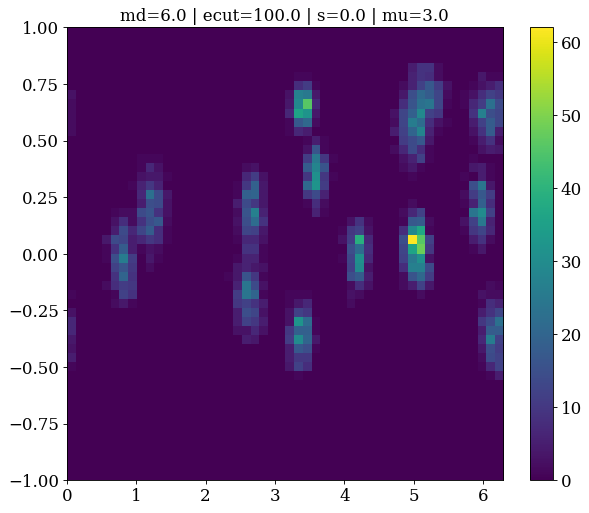

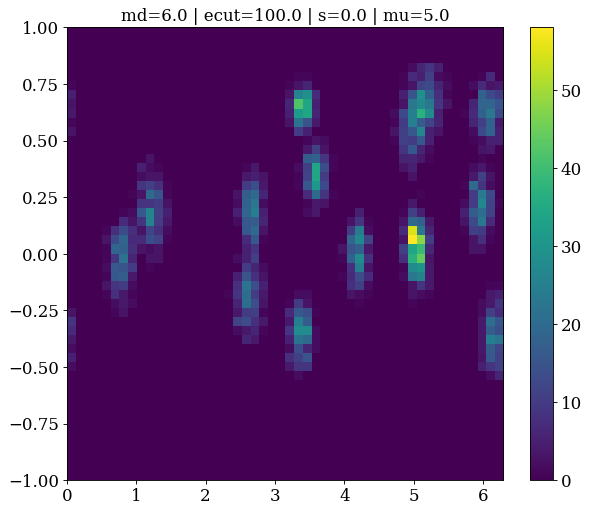

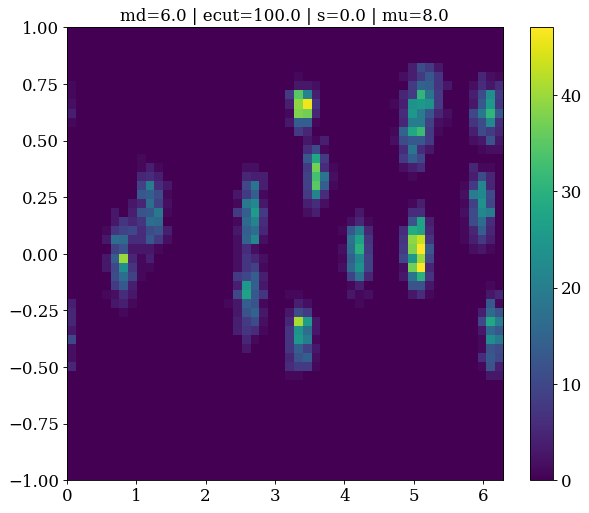

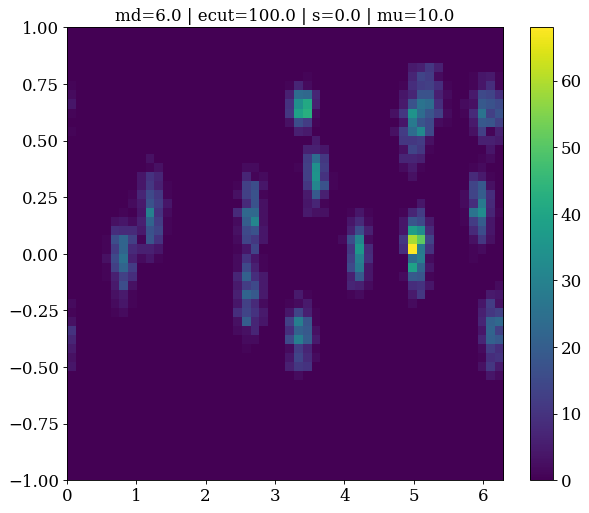

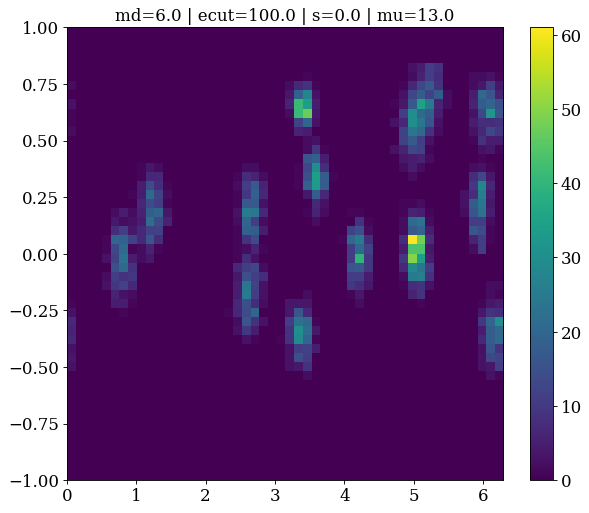

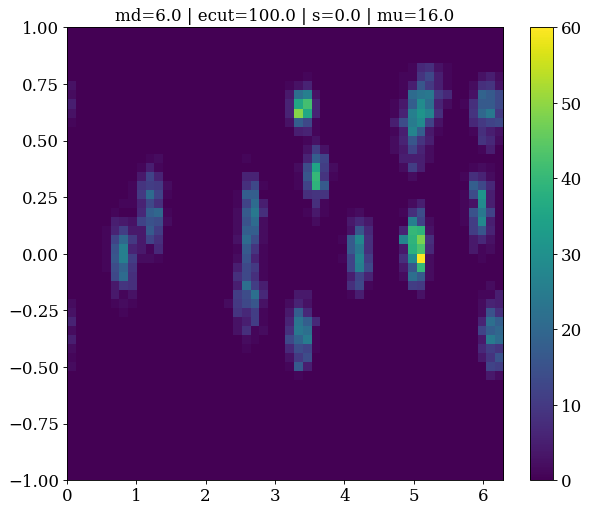

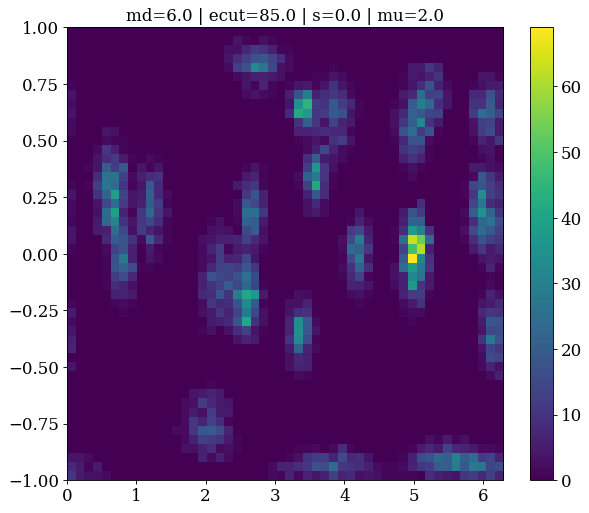

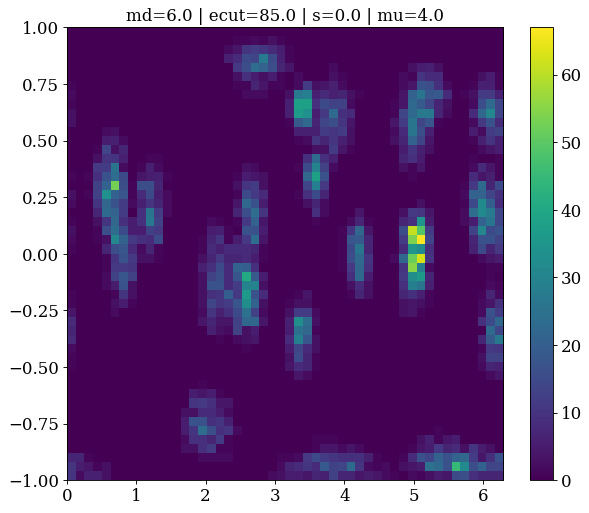

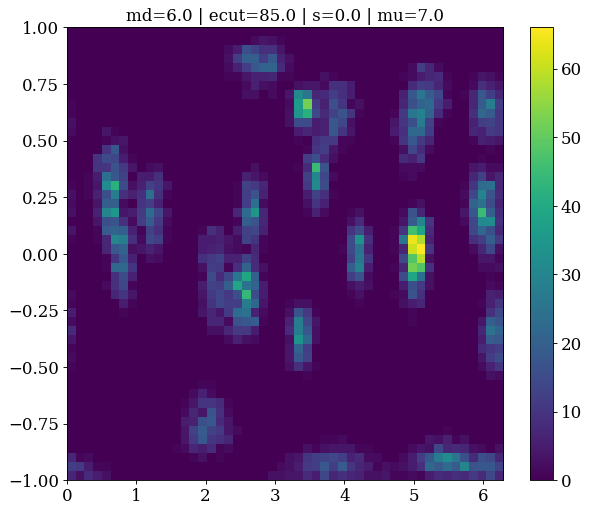

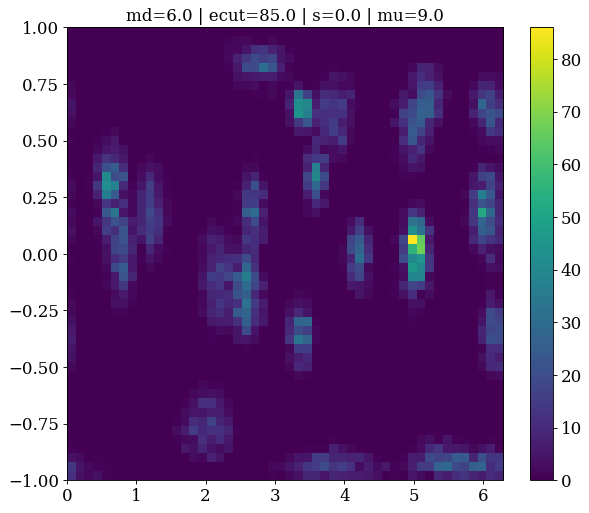

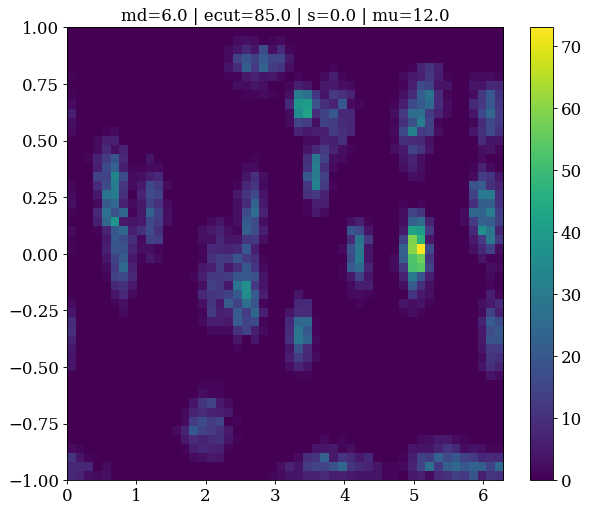

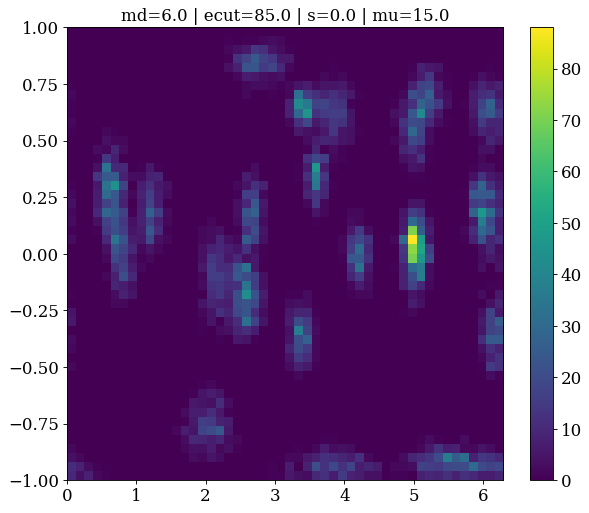

In [57]:
for md in sig_TS:   
    for ecut in sig_TS[md]:
        for s in sig_TS[md][ecut]:
            for i,ak in enumerate(sig_TS[md][ecut][s]):
                sig = np.array(sig_TS[md][ecut][s][ak]["data"])
                plt.figure()
                plt.title("md={} | ecut={} | s={} | mu={}".format(md, ecut, s, ak))
                plt.hist2d(sig['ra_inj'].flatten(), np.sin(sig['dec_inj'].flatten()), 
                           range=[[0, 2*np.pi], [-1, 1]], bins=50
                          )
                plt.ylim(-1, 1)
                plt.xlim(0, 2*np.pi)
                plt.colorbar()

## total flux performance

## performance vs $N_{CR}$

In [ ]:
hspa_sens = np.array([[1.0049827780489007, 2.642232833595364e-12],
[3.964114835393211, 1.318459051646478e-12],
[15.92871563625582, 7.027677347300487e-13],
[63.2219235736235, 3.7459803705646894e-13],
[252.4684748567044, 1.889859884329323e-13],
[995.7152464318317, 8.084371857801016e-14]])

hspa_ul = np.array([[1.0238777858597805, 3.1505858970762185e-12],
[4.013857361055144, 1.5721397314284798e-12],
[16.02991389607907, 8.566327926656099e-13],
[64.4149998273762, 4.82419861799373e-13],
[255.65905736516984, 2.487984516483817e-13],
[995.9886074749862, 1.1000287947343855e-13]])

hspa_sens = hspa_sens.T
hspa_ul = hspa_ul.T


In [ ]:
#"""
tw=8
rcParams = dict()
rcParams["figure.figsize"] = (tw, tw/1.2)
mpl.rcParams.update(rcParams)
#"""
lw1 = 2.
lw2 = 5.
saveplots = True
fig, ax1 = plt.subplots(1)
labels=["sensitivity", r"3$\sigma$ disc."] #, r"5$\sigma$ disc."] 
styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--"),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":"),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-")
             )
proj_styles = defaultdict(sens=dict(lw=lw2, markersize=15, marker="o", linestyle="--", alpha=0.75),
              disc3=dict(lw=lw2, markersize=15, marker="d", linestyle=":", alpha=0.5),
              disc5=dict(lw=lw2, markersize=15, marker="s", linestyle="-", alpha=0.25)
             )
kw = ["sens", "disc3", "disc5"]
"""
plt.plot(ecuts, np.log10(stefan_sens), color="0", label="PS sens. 7yr", **styles["sens"])
#plt.plot(ecuts, np.log10(stefan_disc), color="0.5", label="PS disc.", **styles["disc5"])
#"""
nsrc = [n_cr[e] for e in ecuts]
"""
ndiff = np.linspace(10, 500)
plt.plot(ndiff, np.log10(4.*np.pi*1.01*np.power(10,-18.+3+2*2.19)/ndiff), markersize=0,
           color="black", lw=lw1, linestyle="-", label=r"$\Phi_{\nu_\mu}/N_{CR}$ $\gamma=2.19$")
plt.plot(nsrc, np.log10(4.*np.pi*1.01*np.power(10,-18.+3+2*2.19)/nsrc*0.05), 
           color="gray", lw=lw1, linestyle="-.", label=r"Blazar stacking U.L.")
plt.plot(hspa_sens[0], np.log10(hspa_sens[1]), markersize=0,
           color=utils.colors[0], lw=lw1, linestyle=":", label=r"HSP sensitivity $\gamma=2$")
plt.plot(hspa_ul[0], np.log10(hspa_ul[1]), markersize=0,
           color=utils.colors[0], lw=lw1, linestyle="--", label=r"HSP U.L. $\gamma=2$")
#"""
# split flux into parts for each md value
ff = np.split(np.array(final_flux_percentile), len(mdparams))
md_labels = [r" $3^\circ$", r" $6^\circ$"] #\cdot E/EeV
# then loop over md values
for i,f in enumerate(ff):
    vals = [f[b::len(labels)] for b in xrange(len(labels))]
    for j,vv in enumerate(vals):
        #if j==1: continue
        vx, vy = vv[:, 0], vv[:, 1]
               
        ax1.plot([n_cr[e] for e in vx], np.log10(vy/np.sqrt(7)), 
                 label=labels[j]+md_labels[i],
                 **styles[kw[j]]
                ) 

        
plt.xlim(0.85, 200)
#plt.xlim(min(nsrc)-2, max(nsrc)+20)
plt.ylim(-12.6, -11.3)
plt.semilogx()

plt.grid(True)
ax1.set_xlabel("Number of CR events")
ax1.set_ylabel(r"$\log (\frac{1}{N_{src}} \cdot \Phi_0 \; [\mathrm{TeV}^{-1}\mathrm{cm}^{-2}\mathrm{s}^{-1}])$")
ax1.set_xticks(ticks=nsrc)
ax1.set_xticklabels(labels=nsrc)
plt.legend(ncol=2, loc=1)
plt.title(r"Mean flux per source projected to 7 years $(1/\sqrt{7})$")
if saveplots: plt.savefig(os.path.join(figurepath, "performance", "flux_comparison_vs_NCR_scaled7yr_fitted_gamma.png"))
plt.show()